# Lab: XAI and Uncertainty for Time-Series Forecasting (Panama Load)

You are data scientists at a grid operator in Panama. Your task is short-term load forecasting, interpreting model behaviour (XAI), and estimating predictive uncertainty so operators can make safer operational decisions. This notebook walks you through EDA, feature engineering, training a model, SHAP explanations, temporal attribution with occlusion, bootstrap-based variability, and conformal prediction intervals.

Follow the TODO markers in code cells. The dataset is expected at `data/panama_load.csv` and should contain at least a timestamp column and a load column. Optional covariates (temperature, humidity, etc.) are welcome.

In [28]:
# Section 0 - Setup
# Imports, plotting style, and random seed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import shap
import warnings
warnings.filterwarnings('ignore')

# Plot style and seed
sns.set_style('whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Section 1 — Load data and basic EDA

Goal: understand the time series, inspect seasonality, and spot anomalies. Follow instructions and fill TODOs.

You can learn more about the dataset at: https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting

In [29]:
# 1) Load data into a DataFrame
path = '../data/panama_load.csv'
if not os.path.exists(path):
    print(f'WARNING: {path} not found. Please place the dataset at this path.')
df = pd.read_csv(path)
print(f'Data loaded with shape: {df.shape}')

Data loaded with shape: (48048, 17)


In [30]:
datetime_col = 'datetime' 
load_col = 'nat_demand'  
# Attempt to parse a datetime column robustly
if datetime_col not in df.columns:
    # try to guess a datetime-like column
    for c in df.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            datetime_col = c
            break
print('Using datetime column:', datetime_col)
# Parse datetimes
try:
    df[datetime_col] = pd.to_datetime(df[datetime_col])
except Exception as e:
    print('Error parsing datetimes:', e)
# Set index and sort
df = df.set_index(datetime_col).sort_index()

print('Using load column:', load_col)
# Keep a clean dataframe with at least datetime index and load
data = df[[load_col]].copy()
data.columns = ['load']
data = data.sort_index()
data.head()

Using datetime column: datetime
Using load column: nat_demand


,load
datetime,
2015-01-03 01:00:00,970.3450
2015-01-03 02:00:00,912.1755
2015-01-03 03:00:00,900.2688
2015-01-03 04:00:00,889.9538
2015-01-03 05:00:00,893.6865


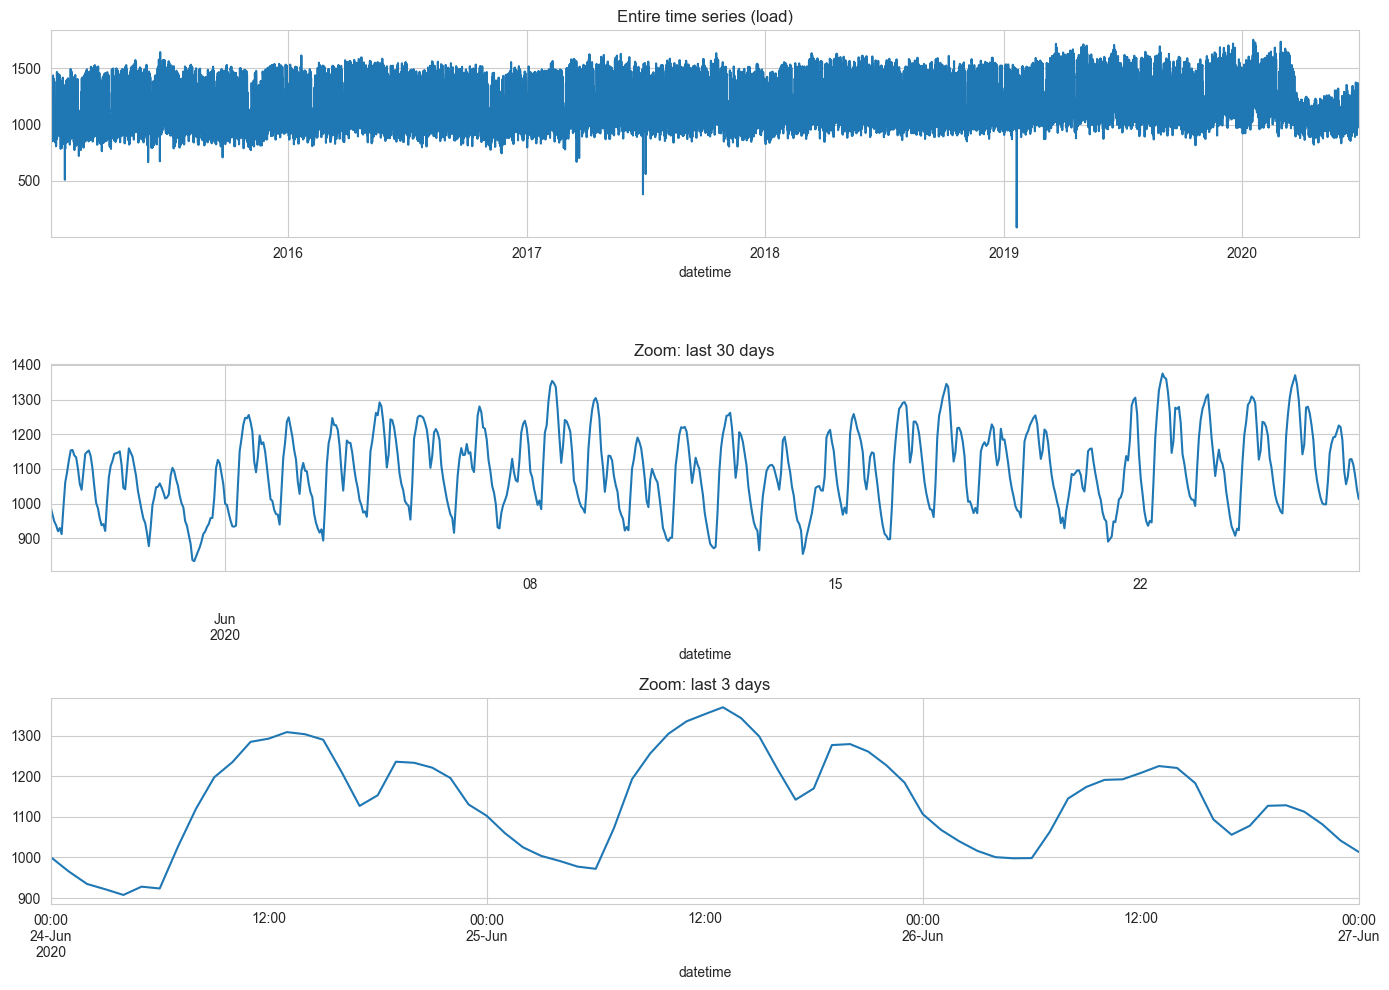

In [31]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Entire series
data['load'].plot(ax=ax[0], title='Entire time series (load)')
# Zoom into one month (choose the last available month)
last = data.index.max()
month_start = (last - pd.Timedelta(days=30)).ceil('D')
data.loc[month_start:last, 'load'].plot(ax=ax[1], title='Zoom: last 30 days')
# Zoom into a couple of days
days_start = (last - pd.Timedelta(days=3)).ceil('D')
data.loc[days_start:last, 'load'].plot(ax=ax[2], title='Zoom: last 3 days')
plt.tight_layout()
plt.show()

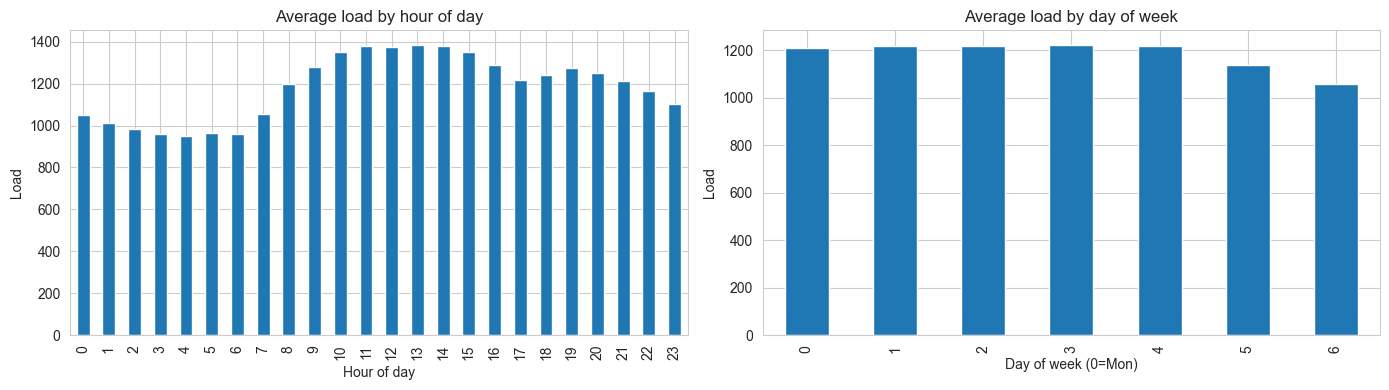

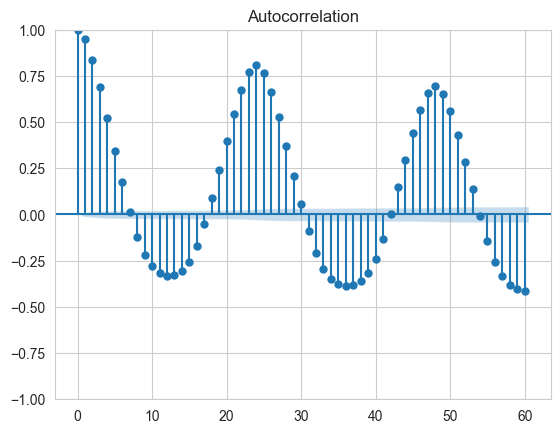

In [32]:
# 3) Average load by hour-of-day and day-of-week
df_feats = data.copy()
df_feats['hour'] = df_feats.index.hour
df_feats['dow'] = df_feats.index.dayofweek
hourly = df_feats.groupby('hour')['load'].mean()
dow = df_feats.groupby('dow')['load'].mean()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
hourly.plot(kind='bar', ax=ax1, title='Average load by hour of day')
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Load')
dow.plot(kind='bar', ax=ax2, title='Average load by day of week')
ax2.set_xlabel('Day of week (0=Mon)')
ax2.set_ylabel('Load')
plt.tight_layout()
plot_acf(data['load'].dropna(), lags=60)
plt.show()


- TODO: Inspect the previous plots and comment on the patterns you can distinguish

>>> Your answer here

>> De las primeras gráficas podemos extraer información muy valiosa. En primer lugar, plottear la serie temporal entera nos da una idea de qué datos estamos utilizando, pero es difícil observar tendencias o estacionalidades en un primer vistazo. Lo que sí observamos es el periodo de menor demanda debido al COVID, a comienzos de 2020, y una serie de outliers uqe no parecen seguir ninguna estructura y que se pueden corresponder con fallos de tensión puntuales. La segunda gráfica, relativa a la demanda en los últimos 30 días, nos proporicona mucha más información. En primer lugar, observamos una clara estructura debida a las horas del día, donde apreciamos una bajada considerable por las noches y una bajada más ligera a mediodía. Además de esto, también observamos una estacionalidad relativa al día de la semana, ya que se distingue una cierta tendencia de subida y bajada cada 7 días, donde los fines de semana presentan valores más bajos. La tercera gráfica, por su parte, detalla la demanda de demanda en los últimos 3 días, permitiéndonos observar el efecto de la hora del día con mayor claridad.

>> Las dos siguientes gráficas presentan valores agregados a lo largo del dataset, por lo que son una forma muy robusta de analizar tendencias generales. Vemos en primer lugar el efecto de la hora del día en la demanda, confirmando las observaciones anteriores. También contemplamos el efecto agregado del día de la semana, confirmando de nuevo lo que se explicaba anteriormente.

>> Por último, la gráfica ACF nos indica la correlación de los valores con sus lags anteriores. Observamos una clara estructura con valores altos en las horas inmediatamente posteriores, ya que se guarda cierta correlación, y también en las horas similares de días anteriores, lo cual explica los picos a las 24 y 48 horas previas y la estructura oscilante.

## Section 2 — Turn time series into supervised learning data

We convert the time series into a tabular supervised problem: predict 1-step-ahead load from lag features, rolling statistics and calendar features.
Fill TODOs in the helper function below.

In [33]:
def make_supervised(df, target_col='load', horizon=1, lags=None):
    """Create supervised features for a 1-step-ahead forecast."""
    if lags is None:
        lags = [1, 24, 48, 168]  # t-1, t-24 (daily), t-48, t-168 (weekly)
    X = pd.DataFrame(index=df.index)
    # Lag features
    for lag in lags:
        X[f'lag_{lag}'] = df[target_col].shift(lag)
    # Rolling features: 24-hour and 7-day rolling mean/std
    X['rmean_24'] = df[target_col].rolling(window=24, min_periods=1).mean().shift(1)
    X['rstd_24'] = df[target_col].rolling(window=24, min_periods=1).std().shift(1)
    X['rmean_168'] = df[target_col].rolling(window=168, min_periods=1).mean().shift(1)
    # Calendar features
    X['hour'] = df.index.hour
    X['dow'] = df.index.dayofweek
    X['is_weekend'] = (X['dow'] >= 5).astype(int)
    X['month'] = df.index.month
    # Target (1-step ahead by default)
    y = df[target_col].shift(-horizon)
    # Align and drop NaNs caused by shifts
    X = X.loc[~y.isna()]
    y = y.loc[X.index]
    return X, y
# Build supervised data
X, y = make_supervised(data, target_col='load', horizon=1)
print('X shape:', X.shape, 'y shape:', y.shape)
# show a few rows
X.head()


X shape: (48047, 11) y shape: (48047,)


,lag_1,lag_24,lag_48,lag_168,rmean_24,rstd_24,rmean_168,hour,dow,is_weekend,month
datetime,,,,,,,,,,,
2015-01-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,1,1
2015-01-03 02:00:00,970.3450,NaN,NaN,NaN,970.345000,NaN,970.345000,2,5,1,1
2015-01-03 03:00:00,912.1755,NaN,NaN,NaN,941.260250,41.132048,941.260250,3,5,1,1
2015-01-03 04:00:00,900.2688,NaN,NaN,NaN,927.596433,37.496964,927.596433,4,5,1,1
2015-01-03 05:00:00,889.9538,NaN,NaN,NaN,918.185775,35.938700,918.185775,5,5,1,1


## Section 3 — Time-based train / calibration / test split

Random splits leak future information in time series. We'll split chronologically: TRAIN (first 60%), CALIBRATION (next 20%), TEST (last 20%). The calibration set will be used for conformal prediction intervals.


In [34]:
# Chronological split
n = len(X)
i_train = int(n * 0.6)
i_cal = int(n * 0.8)
X_train = X.iloc[:i_train]
y_train = y.iloc[:i_train]
X_cal = X.iloc[i_train:i_cal]
y_cal = y.iloc[i_train:i_cal]
X_test = X.iloc[i_cal:]
y_test = y.iloc[i_cal:]
print('TRAIN range:', X_train.index.min(), 'to', X_train.index.max(), 'size', len(X_train))
print('CAL range:', X_cal.index.min(), 'to', X_cal.index.max(), 'size', len(X_cal))
print('TEST range:', X_test.index.min(), 'to', X_test.index.max(), 'size', len(X_test))

TRAIN range: 2015-01-03 01:00:00 to 2018-04-18 04:00:00 size 28828
CAL range: 2018-04-18 05:00:00 to 2019-05-23 13:00:00 size 9609
TEST range: 2019-05-23 14:00:00 to 2020-06-26 23:00:00 size 9610


## Section 4 — Baseline model and ML model

We compare a naive baseline (previous value) to a trained tree-based regressor. Evaluate using MAE and RMSE.


Naive baseline MAE: 78.688, RMSE: 100.701
RandomForest MAE: 39.577, RMSE: 60.170


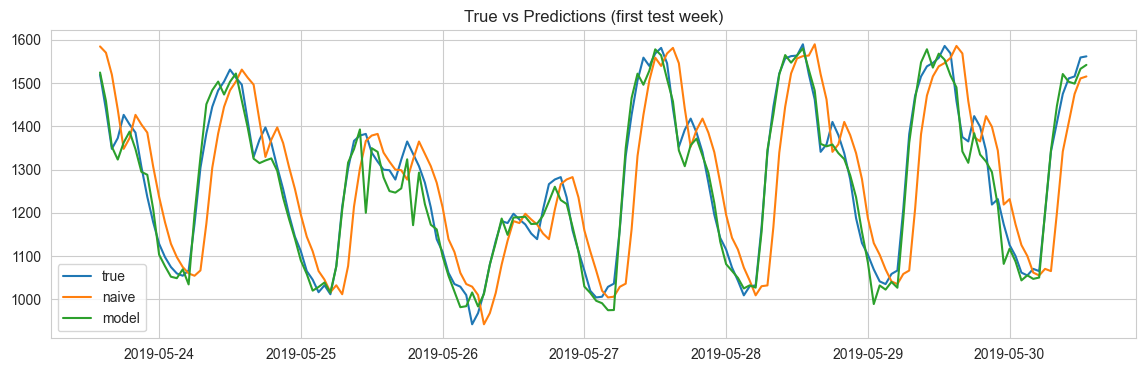

In [35]:
# Naive baseline: predict using lag_1 (t-1). Align carefully.
y_test_index = y_test.index
# Baseline predictions: because target is t, naive is previous observed load at t-1
# which is lag_1 feature
yhat_naive = X_test['lag_1']
# Fit a RandomForest as example ML model (students can replace with XGBoost/LGBM)
# model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
model = RandomForestRegressor(n_estimators=5, random_state=RANDOM_SEED, n_jobs=-1)
# TODO: fit the model on (X_train, y_train)
model.fit(X_train, y_train)
# Predict on test
yhat = pd.Series(model.predict(X_test), index=X_test.index)
# Evaluation
def evaluate(y_true, y_pred, label='model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print(f'{label} MAE: {mae:.3f}, RMSE: {rmse:.3f}')

evaluate(y_test, yhat_naive, label='Naive baseline')
evaluate(y_test, yhat, label='RandomForest')
# Plot a selected TEST week: choose first week of test set
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    idx = (y_test.index >= plot_start) & (y_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[idx].index, y_test.loc[idx].values, label='true')
    plt.plot(yhat_naive.loc[idx].index, yhat_naive.loc[idx].values, label='naive')
    plt.plot(yhat.loc[idx].index, yhat.loc[idx].values, label='model')
    plt.legend()
    plt.title('True vs Predictions (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot test week:', e)

Claramente se ve que el modelo de RandomForest tiene un mejor rendimiento que el baseline utilizado, tanto por la similitud en la gráfica como por las métricas de precisión.

## Section 5 — Global and local XAI with SHAP

We use SHAP to explain feature importance globally and locally. For tree models, TreeExplainer is efficient. For other models, KernelExplainer may be used but is slower.


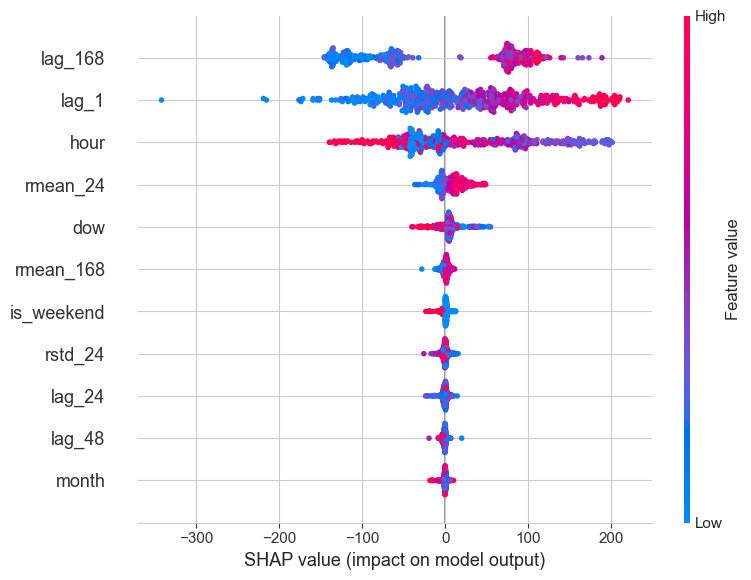

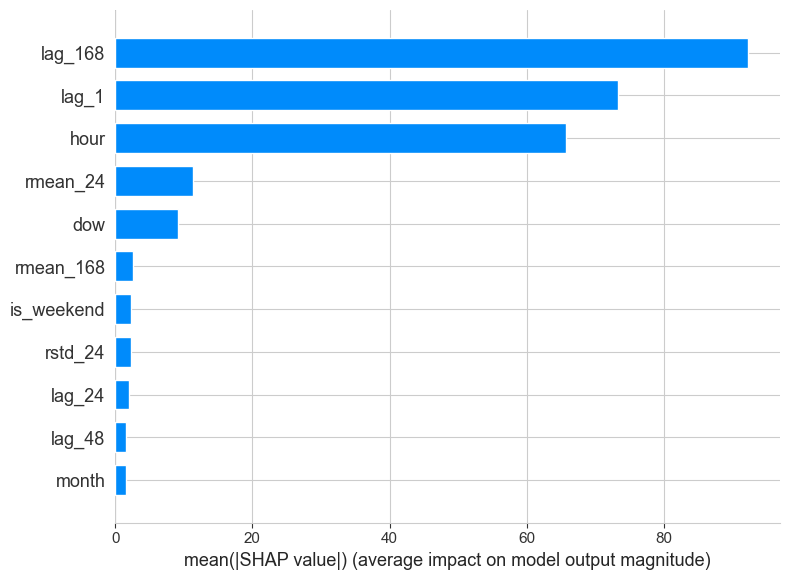

Index with highest load in test: 2020-01-17 13:00:00
Could not produce local SHAP waterfall: The waterfall plot requires an `Explanation` object as the `shap_values` argument.


In [36]:
# Select a subset of X_test for SHAP analysis (to keep compute small)
X_shap = X_test.sample(n=min(500, len(X_test)), random_state=RANDOM_SEED)
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)
# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_shap, show=True)
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=True)
# Local explanation for a single interesting point (e.g., highest true load in test)
idx_max = y_test.idxmax()
print('Index with highest load in test:', idx_max)
x_local = X_test.loc[[idx_max]]
try:
    sv_local = explainer.shap_values(x_local)
    shap.plots.waterfall(sv_local[0] if isinstance(sv_local, list) else sv_local,
                         max_display=12)
except Exception as e:
    print('Could not produce local SHAP waterfall:', e)

- TODO: Interpret SHAP results, are there any innecessary inputs? Try to simplify the model and check performance variations. Does SHAP results match domain intuition?
>>> Your answer here

>> Después de ejecutar SHAP con el modelo de RandomForest con 100 estimadores, vemos una serie de observaciones muy útiles. En particular, vemos que el lag 168 (misma hora de la semana pasada) es una de las variables que más influye en las predicciones del modelo. El lag 1, la hora anterior, también tiene una gran influencia, como era de esperar. En ambos casos, valores altos del lag tienen una influencia positiva sobre la predicción del modelo, mientras que valores más bajos (horas más bajas) tienen una influencia negativa (menor demanda). La hora también influye de manera significativa, pero la relación no es tan lineal como con los lags. Estyo tiene sentido ya que en las horas más altas, cuando ya es de noche, la demanda disminuye bastante. Desde is_weekend hasta lag_48 se puede considerar que son inputs innecesarios, ya que su influencia en la predicción final es prácticamente nula comparada con la de otras variables.

>> Como era de esperar, reducir el número de estimadores de 100 a 25 no cambia demasiado el resultado de SHAP. El orden de las variables es exactamente igual y la importancia de cada una tampoco varía demasiado. Solo se aprecia una influencia más radical de lag_168, concéntrando los puntos rojos y azules en dos clusters totalmente diferenciados.

>> Al utilizar únicamente 5 estimadores, vemos que los resultados son prácticamente iguales al caso anterior. Además, simplificar el modelo no parece afectar notablemente a su rendimiento, ya que sigue prediciendo bastante bien.

>> Por último, analizando los resultados de SHAP, vemos que concuerdan completamente con la intuición previa: la misma hora de la semana pasada suele estar relacionada con la de esta semana, ya que las tendencias de estacionalidad son exactamente iguales. También tiene sentido que el lag previo o la hora del día tengan una gran influencia, ya que están muy relacionadas con la demanda actual. Lo que es algo más llamativo es que los lags_24 y los lags_48 no sean tan influyentes.

## Section 6 — Bootstrap ensemble for predictive variability

Train B bootstrap models (resampling training data with replacement) to approximate variability due to training data sampling. Use their distribution to produce prediction intervals.


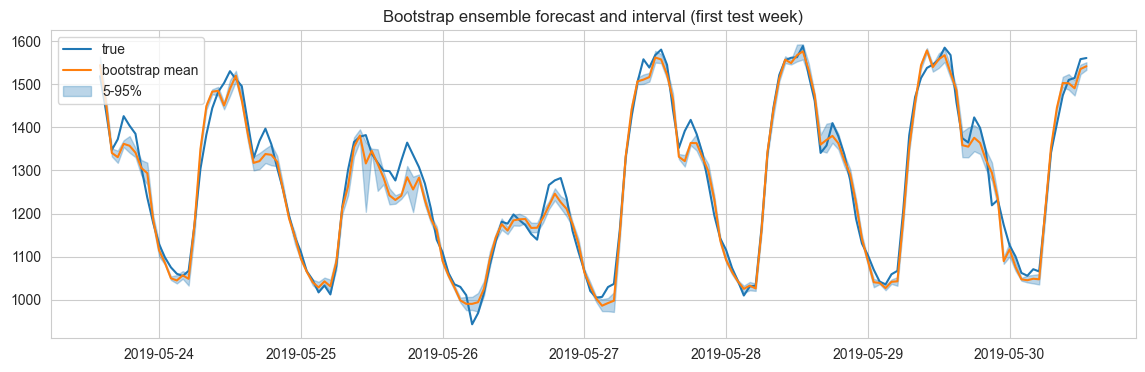

In [37]:
from copy import deepcopy
def bootstrap_models(X_train, y_train, base_model, B=10):
    models = []
    n = len(X_train)
    for b in range(B):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        Xb = X_train.iloc[idx]
        yb = y_train.iloc[idx]
        m = deepcopy(base_model)
        m.fit(Xb, yb)
        models.append(m)
    return models
# Train B bootstrap models (may take time)
B = 10
base = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# TODO: If running time is a concern reduce B or model complexity
models_b = bootstrap_models(X_train, y_train, base, B=B)
# Compute bootstrap predictions for X_test (may be memory heavy;
# sample a week for plotting)
def bootstrap_predict(models, X):
    preds = np.vstack([m.predict(X) for m in models])  # shape (B, n)
    return preds
preds_b = bootstrap_predict(models_b, X_test)
# Mean and 5th-95th percentile interval
y_mean = preds_b.mean(axis=0)
y_p05 = np.percentile(preds_b, 5, axis=0)
y_p95 = np.percentile(preds_b, 95, axis=0)
# Plot a test week with bootstrap interval
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    mask = (X_test.index >= plot_start) & (X_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[mask].index, y_test.loc[mask].values, label='true')
    plt.plot(X_test.loc[mask].index, y_mean[mask], label='bootstrap mean')
    plt.fill_between(X_test.loc[mask].index, y_p05[mask], y_p95[mask], color='C0',
                     alpha=0.3, label='5-95%')
    plt.legend()
    plt.title('Bootstrap ensemble forecast and interval (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot bootstrap week:', e)

## Section 7 — Conformal prediction intervals (inductive residual-based)

Inductive conformal uses residuals on a held-out calibration set to form a distribution of absolute errors; the quantile gives a symmetric interval around point predictions with finite-sample marginal coverage guarantees (under exchangeability).

Conformal q (alpha=0.1): 49.592460000000074
Coverage on TEST (alpha=0.1): 0.750, avg width: 99.185
   alpha         q  coverage  avg_width
0   0.05  66.35182  0.834964  132.70364
1   0.10  49.59246  0.749948   99.18492
2   0.20  35.28676  0.620604   70.57352


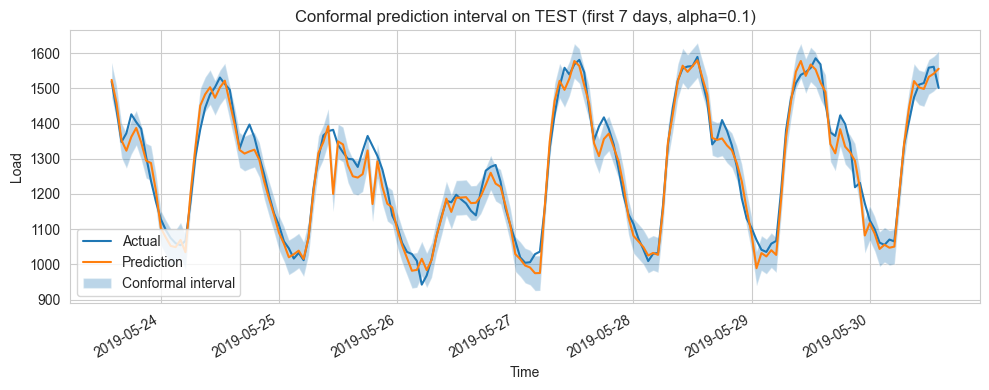

In [39]:
# --- Conformal quantile from calibration residuals ---

# Train a fresh model on TRAIN if desired. We'll reuse `model` already trained, but you can retrain here.
# model.fit(X_train, y_train)

# Predict on calibration set and compute residuals
from pandas import Series


yhat_cal = pd.Series(model.predict(X_cal), index=X_cal.index)
residuals: Series = (y_cal - yhat_cal).abs()

def conformal_q(residuals, alpha=0.1):
    """
    Compute conformal quantile with finite-sample correction:
    quantile at ceil((n+1)*(1-alpha))/n.
    """
    n: int = len(residuals)
    k = int(np.ceil((n + 1) * (1 - alpha))) - 1
    q = np.sort(residuals)[k]
    return q

alpha = 0.1
q_alpha = conformal_q(residuals.values, alpha=alpha)
print(f'Conformal q (alpha={alpha}):', q_alpha)

# --- Build intervals on TEST ---

yhat_test = pd.Series(model.predict(X_test), index=X_test.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha

# Evaluate empirical coverage and average width
inside = ((y_test >= lower) & (y_test <= upper)).mean()
avg_width = (upper - lower).mean()
print(f'Coverage on TEST (alpha={alpha}): {inside:.3f}, avg width: {avg_width:.3f}')

# Optionally loop over several alphas
alphas = [0.05, 0.1, 0.2]
rows = []
for a in alphas:
    q = conformal_q(residuals.values, alpha=a)
    yhat_test_a = pd.Series(model.predict(X_test), index=X_test.index)
    l = yhat_test_a - q
    u = yhat_test_a + q
    cov = ((y_test >= l) & (y_test <= u)).mean()
    rows.append({'alpha': a, 'q': q, 'coverage': cov, 'avg_width': (u - l).mean()})

conformal_summary = pd.DataFrame(rows)
print(conformal_summary)

# --- Plot conformal predictions along the time series (first 7 days of TEST) ---

import matplotlib.pyplot as plt

# Define plot window: first 7 days of the test period
plot_start = X_test.index[0]
plot_end = plot_start + pd.Timedelta(days=7)

mask = (y_test.index >= plot_start) & (y_test.index <= plot_end)

y_test_plot = y_test[mask]
yhat_plot = yhat_test[mask]
lower_plot = lower[mask]
upper_plot = upper[mask]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(y_test_plot.index, y_test_plot, label='Actual')
ax.plot(yhat_plot.index, yhat_plot, label='Prediction')
ax.fill_between(yhat_plot.index, y1=lower_plot, y2=upper_plot, alpha=0.3,
                label='Conformal interval')

ax.set_title(f'Conformal prediction interval on TEST (first 7 days, alpha={alpha})')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

- TODO: Comment on the results, which you find more useful: bootstrap or conformal? Which would you use in case I ask you about uncertainty in forecasting models?
>>> Your comments here

>> Me parece que conformal puede ser más útil por varios motivos. En primer lugar, nos permite cambiar el parámetro alfa, haciéndolo bastante flexible y adaptable a distintas situaciones o modelos. Esto no sucede tanto con bootstratp, donde no tenemos esa capacidad de cambiar un solo hiperparámetro para hacerlo más o menos exigente, sino que estamo limitados a cambiar el número de pruebas que se hacen.

>> También vemos que el resultado de utilizar conformal, al menos con alfa=0.1, nos da un intervalo más grande que bootstrap, lo cual no es necesariamente algo bueno peor puede llegar a ser más informativo. De nuevo, la capacidad de comparar distintos valores de alfa me parece un plus importante.

>> Si hablamos de la incertidumbre en forecasting, entonces conformal es definitivamente preferible, ya que nos permite filtrar por el porcentaje de incertidumbre que queremos tener, lo cual no es posible tan directamente con bootstraping.

## Section 9 — Using intervals for anomaly flagging

Flag times where true load lies outside conformal intervals — potentially anomalous events requiring operator attention.


Number of anomalies in TEST: 2403


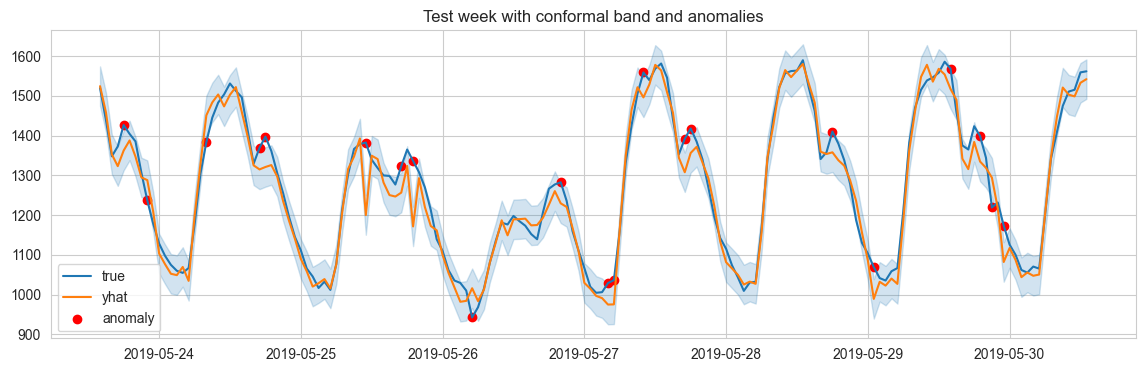

,y_true,yhat,lower,upper,anomaly
datetime,,,,,
2019-05-23 18:00:00,1426.3283,1362.25574,1312.66328,1411.84820,True
2019-05-23 22:00:00,1236.9314,1287.91612,1238.32366,1337.50858,True
2019-05-24 08:00:00,1383.2988,1450.81222,1401.21976,1500.40468,True
2019-05-24 17:00:00,1369.0426,1314.79712,1265.20466,1364.38958,True
2019-05-24 18:00:00,1397.3292,1320.89608,1271.30362,1370.48854,True
2019-05-25 11:00:00,1382.3180,1200.02886,1150.43640,1249.62132,True
2019-05-25 17:00:00,1322.8536,1256.47264,1206.88018,1306.06510,True
2019-05-25 19:00:00,1336.3326,1171.42112,1121.82866,1221.01358,True
2019-05-26 05:00:00,942.4617,1015.96084,966.36838,1065.55330,True


In [40]:
# Using alpha chosen earlier
yhat_test = pd.Series(model.predict(X_test), index=X_test.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha
anomaly = ~( (y_test >= lower) & (y_test <= upper) )
anomalies = pd.DataFrame({'y_true': y_test, 'yhat': yhat_test, 'lower': lower,
                          'upper': upper, 'anomaly': anomaly})
print('Number of anomalies in TEST:', anomalies['anomaly'].sum())
# Plot a test week with anomalies marked
try:
    mask = (X_test.index >= X_test.index[0]) & (X_test.index < X_test.index[0] + pd.Timedelta(days=7))
    plt.figure(figsize=(14, 4))
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'y_true'], label='true')
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'yhat'], label='yhat')
    plt.fill_between(anomalies.loc[mask].index, anomalies.loc[mask, 'lower'],
                     anomalies.loc[mask, 'upper'], color='C0', alpha=0.2)
    # mark anomalies
    an_idx = anomalies.loc[mask & anomalies['anomaly']].index
    plt.scatter(an_idx, anomalies.loc[an_idx, 'y_true'], color='red', label='anomaly')
    plt.legend()
    plt.title('Test week with conformal band and anomalies')
    plt.show()
except Exception as e:
    print('Could not plot anomalies:', e)
# Print a small table of anomalies (timestamp, y_true, yhat, lower, upper)
anomalies[anomalies['anomaly']].head(20)

- TODO: Are the anomalies true grid events or model errors? Justify your answer
>>> Your answer here

>> La mayoría de los casos son puntos en picos que perfectamente pueden tratarse de anomalías y que el modelo detecta perfectamente. Casos más preocupantes son los valores detectados como anomalías en medio de bajadas o subidas, donde no hay ningún valor extremo pero el modelo predice un intervalo demasiado estrecho.

## Section 10 — Visualizing

- How would you present these results to non-technical stakeholders at a grid operator? Include visuals and short bullet recommendations. Add as many code and markdown cells as you find necessary.

Voy a dibujar una serie de gráficas que representen de manera general el comportamiento de los datos, de modo que un operador del sistema pueda entender qué tendencias más complejas se siguen.


In [41]:
path = '../data/panama_load.csv'
if not os.path.exists(path):
    print(f'WARNING: {path} not found. Please place the dataset at this path.')
df = pd.read_csv(path)
print(f'Data loaded with shape: {df.shape}')

Data loaded with shape: (48048, 17)


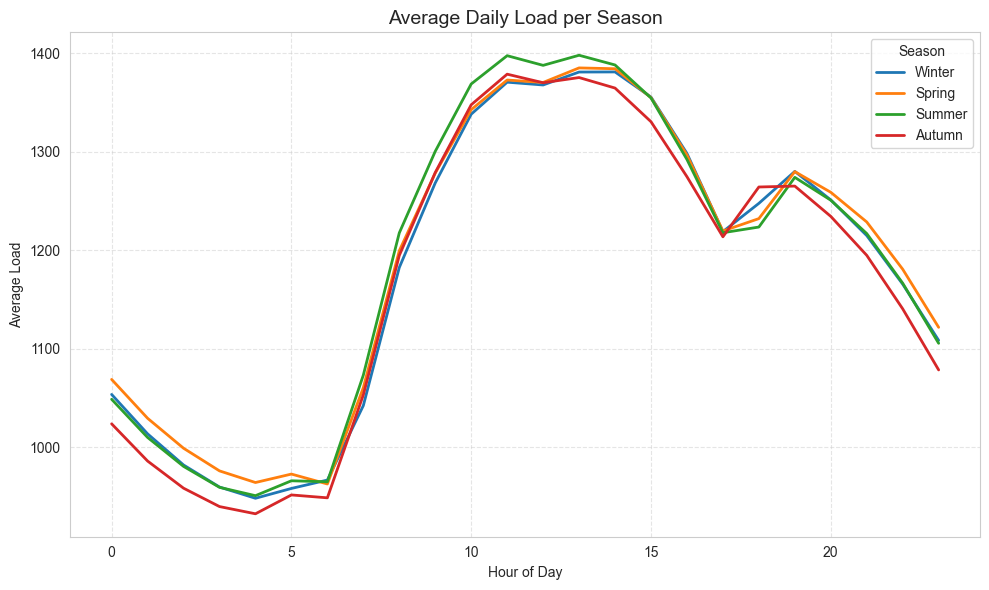

In [42]:
def plot_seasonal_averages(df, load_col='load', datetime_col='datetime'):
    """
    Plot the average daily load curve for each season (3-month blocks).

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime column and a numeric load column.
    load_col : str
        Name of the column containing the load values.
    datetime_col : str
        Name of the column containing datetime values.
    """

    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df.set_index(datetime_col, inplace=True)

    df['month'] = df.index.month
    df['hour'] = df.index.hour

    season_map = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    df['season'] = df['month'].map(season_map)

    seasonal_mean = (
        df.groupby(['season', 'hour'])[load_col]
        .mean()
        .unstack('season')
        .reindex(range(24))
    )

    plt.figure(figsize=(10, 6))
    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        plt.plot(seasonal_mean.index, seasonal_mean[season], label=season, linewidth=2)

    plt.title("Average Daily Load per Season", fontsize=14)
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Load")
    plt.legend(title="Season")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_seasonal_averages(df, load_col='nat_demand', datetime_col='datetime')

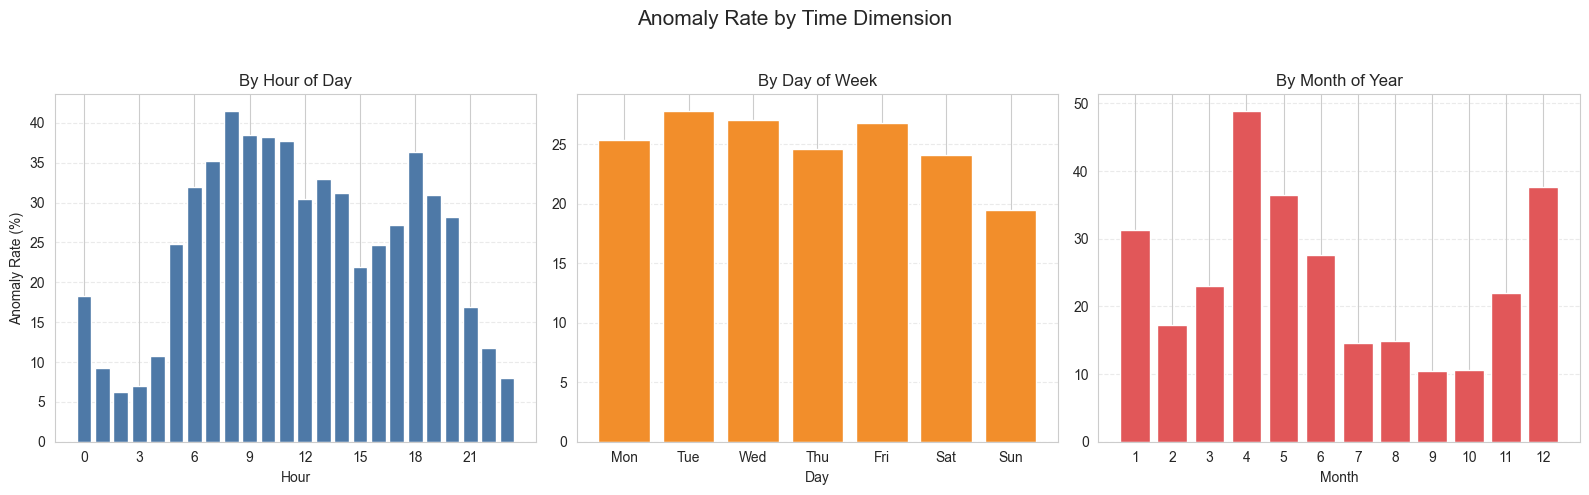

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_anomaly_rates(anomalies_df):
    """
    Plot anomaly rate by hour of day, day of week, and month of year.

    Parameters
    ----------
    anomalies_df : pd.DataFrame
        Must have a DatetimeIndex and a boolean column named 'anomaly'.
    """

    df = anomalies_df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a DatetimeIndex")

    if 'anomaly' not in df.columns:
        raise KeyError("DataFrame must contain a column named 'anomaly'")

    # Extract time components
    df['hour'] = df.index.hour
    df['weekday'] = df.index.dayofweek  # 0=Mon
    df['month'] = df.index.month

    # Compute anomaly rates
    hourly = df.groupby('hour')['anomaly'].mean() * 100
    weekday = df.groupby('weekday')['anomaly'].mean() * 100
    monthly = df.groupby('month')['anomaly'].mean() * 100

    # Labels for weekdays
    weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Anomaly Rate by Time Dimension', fontsize=15)

    # Hour of day
    axes[0].bar(hourly.index, hourly.values, color='#4E79A7')
    axes[0].set_title('By Hour of Day')
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel('Anomaly Rate (%)')
    axes[0].set_xticks(range(0, 24, 3))
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.4)

    # Day of week
    axes[1].bar(range(7), weekday.values, color='#F28E2B')
    axes[1].set_title('By Day of Week')
    axes[1].set_xlabel('Day')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(weekday_labels)
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.4)

    # Month of year
    axes[2].bar(monthly.index, monthly.values, color='#E15759')
    axes[2].set_title('By Month of Year')
    axes[2].set_xlabel('Month')
    axes[2].set_xticks(range(1, 13))
    axes[2].grid(True, axis='y', linestyle='--', alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_anomaly_rates(anomalies)

- Con estas gráficas en mente podemos empezar a explicar comportamientos geenrales y posibles caso sde detcción a los operarios de red. Basándonos en las primeras gráficas, podemos observar claramente que la demanda sigue patrones horarios. Esto significa que cada la relación entre la demanda de las horas del día tiene una estructura claramente definida donde la demanda es alto durante la mañana y la tarde y más baja a mediodía y sobre todo por la noche. También observamos tendencias estacionales, ya que dependiendo de la época del año se demanda un poco más o un poco menos. Siguiendo con estas tendencias, también observamos un patrón semanal, y es que los fines de semana presentan sistemáticamente menor demanda que los dísa laborables.

- Dicho esto, pasamos a hablar de los modelos que hemos utilizado para predecir la demanda a futuro. En primer lugar, hemos preparado un baseline que simplemente predice la temperatura de la hora anterior. Este modelo debería ser fácil de mejorar con técnicas más complejas, pero es un buen punto de partida. Utilizando un modelo más complejo conseguimos predicciones mucho mejores, como podemos ver en las celdas de arriba.

- Pasando a hablar sobre la importancia de las variables, si queremos saber qué demanda va a haber en un momento concreto, nuestra mejor baza es mirar la demanda que hubo a esa hora la semana pasada, ya que es la variable que más influencia tiene en la predicción. También nos puede interesar mirar la demanda en la hora anterior y la hora del día que es, ya que también están muy relacionadas.

- Así, si hablamos de certidumbre o confianza en las predicciones del modelo, también tenemos un modelo que nos saca una franja de demanda esperada donde podemos establecer el porcentaje de seguridad con el que queremos que la demanda final caiga dentro. Este mismo sistema nos sirve para detectar anomalías en la red, que secuderán cuando la realidad caiga fuera de nuestro intervalo esperado. En ese momento, son los operarios de red los que tienen que acudir a la reparación.

- Para una comprensión más general, observamos cómo varía la demanda media a lo largo de un día en función de la estación que sea. Vemos que por la noche la primavera suele presentar una mayor demanda, mientras que el otoño se queda por debajo del resto. A lo largo del día, la demanda suele ser más alta en verano, hasta que vuelve a caer la noche.

- Por último, tenemos también conocimiento sobre el ratio de anomalías en función de la hora del día, el día de la semana y el mes del año. Respecto a la hora del día, cabía epsrar que hubiese más anomalías cuando la demanda es más alta. Vemos en la gráfica que claramente se cumple esta suposición. Hay picos a las 8 AM y 6 PM ue conviene tener en cuenta para preparar más personal. Considerando las anomalías a lo largo de la semana, nuevamente los días con menor demanda presentan menos anomalías, aunque hay cierta variación a lo largo de los días laborables. Finalmente, una gráfica muy interesante nos muestra las anomalís medias en función de cada mes. Observamos cómo en primavera y los primeros meses de invierno suelen presentar un mayor ratio, posiblemente debido a las condiciones metereológicas de lluvia o viento.